In [4]:
import numpy as np
import simpy
import random
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

# [Problem 1: Deriving Average Wait Times for M/M/1 vs. M/M/C Queues]

# Average Waiting Time for M/M/1 Queues 

$E(W)_{M/M/1} = \frac{E(L)_{M/M/1}}{\lambda}$ (Little's Law)

$E(L)_{M/M/1} = \Sigma{n*p_n}$

$\text{Since } p_n = (1-\rho)*\rho^n \text{, then } E(L)_{M/M/1} = \Sigma {n*(1-\rho)*\rho^n}$

$\text{Recall } \Sigma \rho^n = \frac{1}{1-\rho} \text{ by the Geometric Series}$

$\text{Then, we can differentiate both sides: } \frac{d}{d\rho} \Sigma \rho^n = \frac{d}{d\rho} \frac{1}{1-\rho} $

$\text{We get: } \Sigma n*\rho^{n-1} = \frac{1}{(1-\rho)^2}$ 

$\text{Therefore, } \Sigma n*p^n = \frac{\rho}{(1-\rho)^2}$

$\text{And } (1-\rho) * \Sigma n*\rho^n = \frac{\rho}{1-\rho}$

$\text{E(L)}_{M/M/1} = \frac{\rho}{1-\rho} = \frac{\frac{\lambda}{\mu}}{1-\rho}$

${E(W)}_{M/M/1} = \frac{{E(L)}_{M/M/1}}{\lambda} = \frac{1}{\mu*(1-\rho)}$

$\text{------------------------------------------------------------------}$

# Average Waiting Time for M/M/C Queues 
$E(W)_{M/M/C} = \frac{E(L)_{M/M/C}}{\lambda}$ (Little's Law)

$E(L)_{M/M/C} = \Sigma{n*p_{n+c}} = \Sigma{n*p^n*p_c}$

$ = p_c\Sigma{n*p^n}$

$ \text{Following logic from previous section, } \Sigma{n*p^n*p_c} = p_c * \frac{\rho}{(1-\rho)^2}$

$ = \frac{p_c}{1-\rho} * \frac{\rho}{1-\rho}$

$ \text{Since } \frac{p_c}{1-\rho} = \Pi_w \text{ and } \rho = \frac{\lambda}{n*\mu} \text{, then } E(L)_{M/M/C} = \Pi_w * \frac{\lambda}{(1-\rho)*n*\mu}$

$ \text{Therefore, } E(W)_{M/M/C} = \frac{\Pi_w}{(1-\rho)*n*\mu}$

$ \Pi_w \text{ is always <= 1 since it is the probability that a job has to wait. Therefore, } E(W)_{M/M/C} \text{ will always be lower than } E(W)_{M/M/1} \text{ by at least a factor of n.}$








# [Problem 2: DES Program to Verify Results]

In [5]:
class MMCQueueSimulation:
    def __init__(self, env, lambd, mu, n):
        '''
        Initializes object values in environment.
        Parameters:
        ----------
        lambd: Arrival rate into the system (λ)
        mu: Capacity of each server (μ)
        n: Number of servers
        '''
        self.env = env
        self.lambd = lambd
        self.mu = mu
        self.n = n
        self.servers = simpy.Resource(env, capacity=n)
        self.waiting_times = []
    
    def service_process(self):
        '''
        Process for each customer in the system. 
        '''
        arrival_time = self.env.now

        with self.servers.request() as request:
            # Wait for request
            yield request
            
            # Calculate and store waiting time after request has been approved
            waiting_time = self.env.now - arrival_time
            self.waiting_times.append(waiting_time)
            
            service_time = np.random.exponential(1/self.mu)
            
            # Simulate service
            yield self.env.timeout(service_time)
    
    def arrival_process(self):
        '''
        Generates customer arrivals with exponential times between arrivals.
        '''
        while True:
            # Calculate time until arrival
            yield self.env.timeout(np.random.exponential(1/self.lambd))
            
            # Continue to service process after arrival
            self.env.process(self.service_process())
    
    def average_wait_time_run(self, simulation_time):
        self.env.process(self.arrival_process())
        self.env.run(until=simulation_time)
        avg_waiting_time = np.mean(self.waiting_times) if self.waiting_times else 0
        return avg_waiting_time


In [6]:
lambd = 9
mu = 10
simulation_time = 10000
num_simulations = 3
n_list = [1, 2, 4]  
avg_wait_times = []
var_wait_times = []

for n in n_list:
    for i in range(num_simulations):
        env = simpy.Environment()
        simulation = MMCQueueSimulation(env, lambd, mu, n)
        avg_wait_time = simulation.average_wait_time_run(simulation_time)
        print(f'Run {i+1}')
        print(f'Number of servers (n): {n}, Average Waiting Time: {avg_wait_time: .2f}')
    print('-')

Run 1
Number of servers (n): 1, Average Waiting Time:  0.81
Run 2
Number of servers (n): 1, Average Waiting Time:  0.96
Run 3
Number of servers (n): 1, Average Waiting Time:  0.88
-
Run 1
Number of servers (n): 2, Average Waiting Time:  0.02
Run 2
Number of servers (n): 2, Average Waiting Time:  0.03
Run 3
Number of servers (n): 2, Average Waiting Time:  0.03
-
Run 1
Number of servers (n): 4, Average Waiting Time:  0.00
Run 2
Number of servers (n): 4, Average Waiting Time:  0.00
Run 3
Number of servers (n): 4, Average Waiting Time:  0.00
-


In [7]:
def get_confidence(lambd, mu, num_servers, simulation_time, num_runs):
    '''
    Run simulations and return confidence intervals for given values of rho
    Args:
        lambd (float): Arrival rate (customers per unit time)
        mu (float): Service rate (customers served per unit time per server)
        num_servers (int): Number of serves in the system
        simulation_time (float): Total time units to run the simulation over
        num_runs (int): Number of times to run the simulation

    Returns:
        A dictionary with :
        -rho (float): System load
        -mean_wait (float): Mean of all the wait times
        -ci_width (float): Width of the confidence interval for the mean waiting time
        -std_dev (float): Standard Deviation of the waiting times
    '''
    rho = lambd / (num_servers * mu)# Calculating the value of rho

    avg_wait_times = []
    for _ in range(num_runs):
        env = simpy.Environment()
        sim = MMCQueueSimulation(env, lambd, mu, num_servers)
        avg_wait = sim.average_wait_time_run(simulation_time)
        avg_wait_times.append(avg_wait)

    mean_wait = np.mean(avg_wait_times)
    std_dev = np.std(avg_wait_times)
    std_error = std_dev / np.sqrt(num_runs)
    confidence_interval = stats.t.interval(0.95, num_runs - 1, loc=mean_wait, scale=std_error)# Finding the width of the confidence interval for the mean waiting time using the t-distribution

    return {
        "rho": rho,
        "mean_wait": mean_wait,
        "ci_width": np.diff(confidence_interval)[0],
        "std_dev": std_dev,
    }# Return a dictionary with values of rho, mean wait times, width of confidence intervals, standard deviation


In [8]:
def analyze_rho_dependence(mu, num_servers, rho_values, simulation_time, num_runs_list):
    '''
    Model behaviour of confidence intervals for different values of rho

    Args:
        mu (float): Service rate (customers served per unit time per server)
        num_servers (int): Number of serves in the system
        rho_values (List): Containg all the values of rho to iterate over
        simulation_time (float): Total time units to run the simulation over
        num_runs (int): Number of times to run the simulation

    Returns:
      list of dictionaries containing rho, mean wait tines , confidence intervals, standard deviations, number of simulations runs
    '''
    results = []
    for rho in rho_values:
        lambd = rho * num_servers * mu #C alculate value of Lmabda
        for num_runs in num_runs_list:
            result = get_confidence(lambd, mu, num_servers, simulation_time, num_runs)# Get dictionary containing the values of rho, mean wait times, width of confidence intervals, standard deviation
            result["num_runs"] = num_runs
            results.append(result)
    return results

In [9]:
def plot_confidence_intervals(results, num_servers):
    '''
    Plots confidence interval widths as a function of ρ and number of runs.
    Args:
      results (List): List of dictionaries containing rho, mean wait times, width of the confidence intervals, standard deviation and the number of runs
      num_servers (int): Number of servers in the system

    '''
    plt.figure(figsize=(12, 8))
    #Iterate through unique value of rhos in ascending order
    for rho in sorted(set(res["rho"] for res in results)):
        rho_results = [res for res in results if res["rho"] == rho]
        num_runs = [res["num_runs"] for res in rho_results]
        ci_widths = [res["ci_width"] for res in rho_results]#Find the width of the confidence interval for the current rho value

        plt.plot(num_runs, ci_widths, label=rf"$\rho$ = {rho:.2f}", marker='o')

    plt.title(f"Confidence Interval Width vs Number of Simulations for M/M/{num_servers}", fontsize=16)
    plt.xlabel("Number of Simulations", fontsize=14)
    plt.ylabel("Confidence Interval Width", fontsize=14)
    plt.legend(title=r"System Load ($\rho$)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

    plt.show()

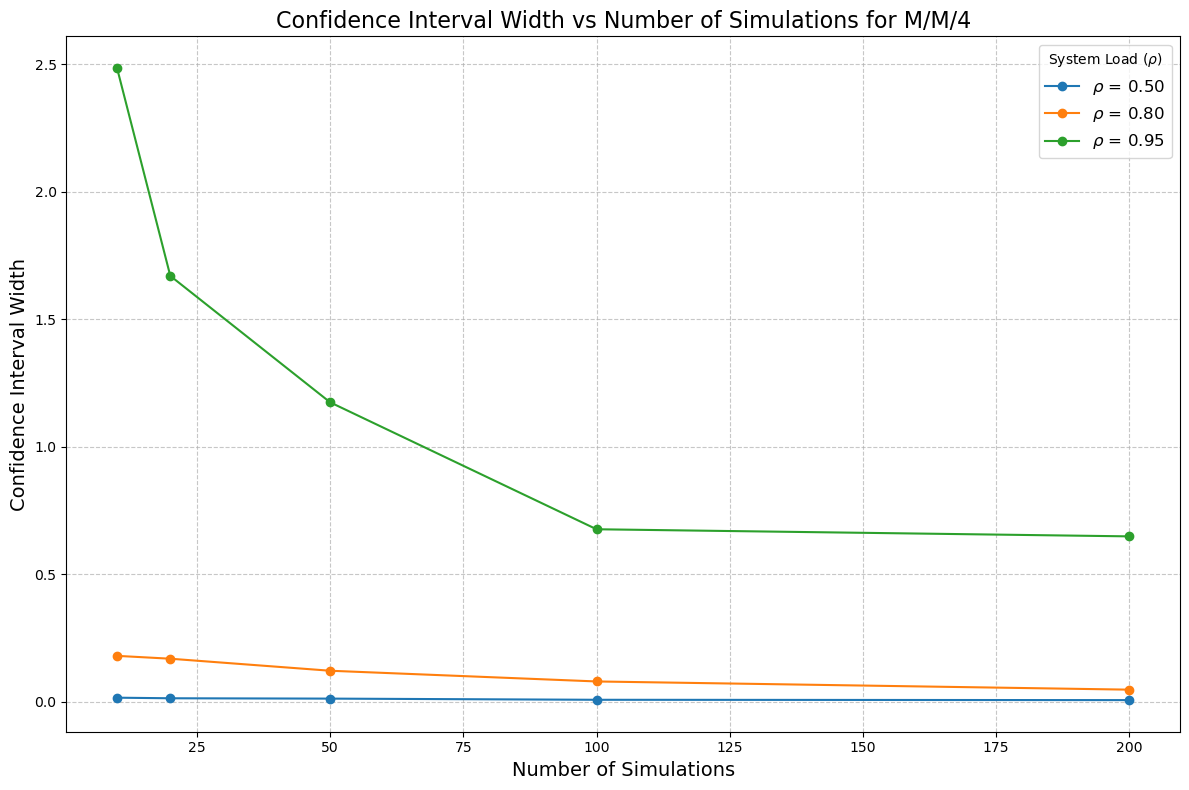

In [10]:
mu = 1.0
simulation_time = 1000
num_servers = 4
rho_values = [0.5, 0.8, 0.95] # Values of rho for which the confidence intervals must be plotted
num_runs_list = [10, 20, 50, 100, 200]
results = analyze_rho_dependence(mu, num_servers, rho_values, simulation_time, num_runs_list)
plot_confidence_intervals(results, num_servers)